# Demo de implementación de un algoritmo de Programación Genética para obtener una fórmula matemática que se aproxime al comportamiento de un conjunto de datos
Ejemplo adaptado de https://deap.readthedocs.io/en/master/examples/gp_symbreg.html
Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

In [1]:
#@title Instalar librerías

# instala paquetes DEAP
!pip install deap

# instala paquetes gráficos
!apt-get install -y graphviz-dev
!pip install pygraphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 20 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,03

In [2]:
#@title Cargar librerías
import random
import numpy as np

import operator
import math

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import matplotlib.pyplot as plt
import pygraphviz as pgv
from IPython.display import display
import tempfile
from PIL import Image
#import networkx as nx

print("\nLibrerías importadas")


Librerías importadas


In [3]:
#@title GENERAR DATOS DE LA FUNCIÓN A APROXIMAR

# toma datos de entrada de 0 a 100
# y determina el valor de salida correspondiente
ENTRADA = range(101)
SALIDA = []
for x in ENTRADA:
  # fórmula a aproximar
  SALIDA.append( 5*x + 1 )

print("Entradas: ", list(ENTRADA))
print("Salidas: ", SALIDA)

Entradas:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
Salidas:  [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311, 316, 321, 326, 331, 336, 341, 346, 351, 356, 361, 366, 371, 376, 381, 386, 391, 396, 401, 406, 411, 416, 421, 426, 431, 436, 441, 446, 451, 456, 461, 466, 471, 476, 481, 486, 491, 496, 501]


In [4]:
#@title DEFINIR FUNCIÓN DE APTITUD y PRIMITIVAS DEL CROMOSOMA


#@markdown > Función de Aptitud:
#@markdown - indica que es para minimizar.
#@markdown - determina la aptitud a partir de la sumatoria del error generado con los datos generados y considerando la cantidad de operadores del cromosoma (para reducir BLOAT).

# parámetro que se usa para penalizar expresiones muy largas
Cant_Operadores_Empieza_Penalizar = 15 #@param {type:"integer"}

## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

## PRIMITIVAS QUE SE VAN A UTILIZAR
## PARA GENERAR EL ÁRBOL DE LA FÓRMULA MATEMÁTICA
def pDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(pDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("ca"+str(random.randint(0,100)), lambda: random.randint(-99,99))
pset.addEphemeralConstant("cb"+str(random.randint(0,100)), lambda: random.randint(-99,99))

pset.renameArguments(ARG0='x')

print("\nPrimitivas definidas")

# indica que es la función de aptitud es para minimizar el error
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def calculaError(individual):
    # Transforma la expresión del árbol en una función que se puede ejecutar
    try:
      func = toolbox.compile(expr=individual)
    except MemoryError:
      # si tira error por BLOAT devuelve un error muy grande para descartarlo
      return 9223372036854775807,

    try:
      # calcula la diferencia entre lo que devuelve la función y el valor Y
      sqerrors = ((func(x) - y)**2 for x, y in zip(ENTRADA, SALIDA))
      # calcula el promedio del error total
      errorTotal = math.fsum(sqerrors) / len(ENTRADA)
    except OverflowError:
      # si tira error por superarar máximo de float en el error calculado, devuelve error muy grande
      return 9223372036854775807,

    # penaliza según la cantidad de métodos aplicados
    cantMetodosAplicados = str(individual).count('(') - Cant_Operadores_Empieza_Penalizar
    if cantMetodosAplicados >= 0:
      errorTotal = errorTotal + cantMetodosAplicados*5

    # devuelve aptitud / error total
    return errorTotal,

toolbox.register("evaluate", calculaError)

print("\nFunción de Aptitud y Cromosoma definidos")


Primitivas definidas

Función de Aptitud y Cromosoma definidos


/usr/local/lib/python3.11/dist-packages/deap/gp.py:257: RuntimeWarning: Ephemeral ca6 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "
/usr/local/lib/python3.11/dist-packages/deap/gp.py:257: RuntimeWarning: Ephemeral cb4 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


In [5]:
#@title  OPERADORES GENÉTICOS
## (ver lista completa en https://deap.readthedocs.io/en/master/api/tools.html#operators )

tipo_seleccion = 'Torneo' #@param ["Azar", "Torneo", "Ranking", "Ruleta" ]

#@markdown  #####tipo_cruzamiento = 'Simple 1 punto corte'

# Probabilidad del Mutación
probab_mutacion = 0.35  #@param {type:"slider", min:0, max:1, step:0.05}

# Registrar tipo de Selección a aplicar con sus parámetros
if tipo_seleccion == 'Torneo':
  toolbox.register("select", tools.selTournament, tournsize=2)
elif tipo_seleccion == 'Ranking':
  toolbox.register("select", tools.selBest)
elif tipo_seleccion == 'Ruleta':
  toolbox.register("select", tools.selRoulette)
else:
  toolbox.register("select", tools.selRandom)

# Registrar tipo de Cruzamiento a aplicar con sus parámetros
toolbox.register("mate", gp.cxOnePoint)

# Registrar tipo de Mutación a aplicar con sus parámetros
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# define parámetros adicionales para evitar el BLOAT
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=15))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))

print("\nOperadores Genéticos definidos")


Operadores Genéticos definidos


In [6]:
#@title PÁRÁMETROS DE LA CORRIDA

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 500 #@param {type:"integer"}

# Indica que finaliza corrida cuando se alcance una  Diferencia Máxima (opcional)
FINALIZA_CORRIDA_POR_MAX_APTITUD = True #@param {type:"boolean"}
FINALIZA_CORRIDA_VAL_MAX_APTITUD = 0.1 #@param {type:"slider", min:0, max:10, step:0.1}

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 50 #@param {type:"slider", min:1, max:100, step:1}


print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


In [7]:
#@title FUNCIONES AUXILIARES

## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra, mejorMax = True):
    global mejorIndCorrida, mejorIndCorrida_ciclo
    global ciclosMaxAptitud
    global ciclosPromAptitud
    global ciclosMinAptitud
    if len(indivPobla) == 0:
      return None, 0, 0, 0
    auxMax = None
    auxMin = None
    auxSum = 0
    auxBestInd = None
    auxBestIndApt = None
    for ind in indivPobla:
        apt = round(ind.fitness.values[0], 2)
        auxSum = auxSum + apt
        if (auxMax == None) or (apt > auxMax):
            auxMax = apt
            if mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt
        if (auxMin == None) or (apt < auxMin):
            auxMin = apt
            if not mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt
    auxProm = round(auxSum / len(indivPobla), 2)
    if mejorMax:
      if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values < auxBestInd.fitness.values):
            mejorIndCorrida = auxBestInd
            mejorIndCorrida_ciclo = ciclo
    else:
      if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values > auxBestInd.fitness.values):
            mejorIndCorrida = auxBestInd
            mejorIndCorrida_ciclo = ciclo
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )
    if muestra:
        print("\n-- Ciclo  %i --" % ciclo)
        print(" ++ Mejor Individuo:", auxBestInd, " {", round(auxBestIndApt, 3), "}")
        print("      Max: ", round(auxMax, 3), " / Promedio: ", round(auxProm, 3), " / Min: ", round(auxMin, 3))
    return auxBestInd, auxMax, auxProm, auxMin


def asignarAptitud(indivPobla):
  # Asigna el valor de aptitud a los individuos
  fitnesses = list(map(toolbox.evaluate, indivPobla))
  for ind, fit in zip(indivPobla, fitnesses):
      ind.fitness.values = fit


def mostrarParamsDetalle():
  print("EJECUCIÓN DE LA CORRIDA: ")
  print("\t Criterio de Paro: "+str(CANT_CICLOS)+" ciclos, o si llega a una heurística mayor a: ", round(MIN_HEURISTICA_FINALIZAR,3) )
  print("\t Tamaño de la Población: "+str(CANT_INDIVIDUOS_POBLACION)+" individuos.")
  print("\t Método de Selección: "+tipo_seleccion+".")
  print("\t Método de Cruzamiento: "+tipo_cruzamiento+".")
  print("\t Método de Mutación: Simple con "+str(probab_mutacion*100)+"% de probabilidad.")
  print("")


def mostrarPoblaDetalle(indivPobla, titulo=""):
  if titulo != "":
    print("\n" + titulo)
  for ind in indivPobla:
    print("\t", formatearIndividuo(ind), " { ", formatearAptitud(ind.fitness.values[0]), " } ")
  print("")

print("\nFunciones auxiliares definidas")


Funciones auxiliares definidas


In [12]:
#@title EJECUCIÓN DE LA CORRIDA

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True  #@param {type:"boolean"}

# cálcula cantidad de individuos seleccionados como la mitad + 1
cant_ind_selecc = (CANT_INDIVIDUOS_POBLACION//2)+1

# vectores auxiliares
ciclo = 1
mejorIndCorrida = None
mejorIndCorrida_ciclo = 0
ciclosIndiv = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []

# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)

# Asigna el valor de aptitud a los individuos de la población inicial
asignarAptitud(indivPobla)
ciclosIndiv.append( [] )
ciclosIndiv[0].extend( indivPobla )

# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS, mejorMax=False)

# Finaliza cuando llegue a la cantidad de ciclos
#     o cuando la heurística del mejor sea mayor a un mínimo
while (ciclo < CANT_CICLOS) \
        and (not(FINALIZA_CORRIDA_POR_MAX_APTITUD) or (mejorIndCorrida==None) or (mejorIndCorrida.fitness.values[0] > FINALIZA_CORRIDA_VAL_MAX_APTITUD)):

    # Realiza la Selección
    indivSelecc = toolbox.select(indivPobla, cant_ind_selecc)

    # Realiza el Cruzamiento
    # por cada individuo seleccionado los clona (sino pueden afectarle los cambios)
    # y luego le busca una pareja al azar dentro de los seleccionados para generar 2 hijos
    indivHijos = []
    for hijo1 in list(map(toolbox.clone, indivSelecc)):
      if len(indivHijos) < len(indivPobla):
        # todavía falta generar hijos
        hijo2 = list(map(toolbox.clone, random.sample(indivSelecc, 1)))[0]
        # hace el cruzamiento
        toolbox.mate(hijo1, hijo2)
        del hijo1.fitness.values
        del hijo2.fitness.values
        # agrega 1er hijo
        indivHijos.append(hijo1)
        if len(indivHijos) < len(indivPobla):
          # agrega 2do hijo
          indivHijos.append(hijo2)
      else:
        break

    # controla que mantenga que los hijos
    # tenga la misma cantidad de individuos que la población original
    if len(indivHijos) != len(indivPobla):
      print("ERROR: distinta cantidad de individuos hijos ", len(indivHijos) , " | ", len(indivPobla))

    # Realiza la Mutación
    if random.random() < probab_mutacion:
      # ejecuta mutación:
      # selecciona al azar el individuo a mutar
      # y lo muta aplicando el método
      mutant = indivHijos[random.randint(0, len(indivHijos)-1)]
      # hace la mutación
      toolbox.mutate(mutant)
      del mutant.fitness.values

    # Evalua a los individuos hijos que salen de Cruzamiento & Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivHijos if not ind.fitness.valid]
    asignarAptitud(invalid_ind)

    # Reemplaza la población actual con los hijos
    indivPobla[:] = indivHijos
    ciclosIndiv.append( [] )
    ciclosIndiv[ciclo].extend( indivPobla )

    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS, mejorMax=False)

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )

print("== Mejor Individuo de la Corrida:", mejorIndCorrida, "\n    { ", round(mejorIndCorrida.fitness.values[0], 3), " }  ==")


-- Ciclo  0 --
 ++ Mejor Individuo: sub(x, -73)  { 29984.0 }
      Max:  59732371.0  / Promedio:  1742379.26  / Min:  29984.0

-- Ciclo  1 --
 ++ Mejor Individuo: add(x, 83)  { 27524.0 }
      Max:  159481.0  / Promedio:  80892.42  / Min:  27524.0

-- Ciclo  2 --
 ++ Mejor Individuo: sub(add(x, x), sub(-18, 17))  { 21106.0 }
      Max:  2110465.57  / Promedio:  112204.79  / Min:  21106.0

-- Ciclo  3 --
 ++ Mejor Individuo: sub(add(x, x), -18)  { 25339.0 }
      Max:  6492165.95  / Promedio:  270869.57  / Min:  25339.0

-- Ciclo  4 --
 ++ Mejor Individuo: add(add(x, x), add(x, x))  { 3451.0 }
      Max:  105676.0  / Promedio:  59926.96  / Min:  3451.0

-- Ciclo  5 --
 ++ Mejor Individuo: add(add(x, x), add(x, x))  { 3451.0 }
      Max:  132361.0  / Promedio:  54351.47  / Min:  3451.0

-- Ciclo  6 --
 ++ Mejor Individuo: add(add(x, x), add(x, x))  { 3451.0 }
      Max:  83924.84  / Promedio:  30271.86  / Min:  3451.0

-- Ciclo  7 --
 ++ Mejor Individuo: add(77, add(add(add(x, x), x), x

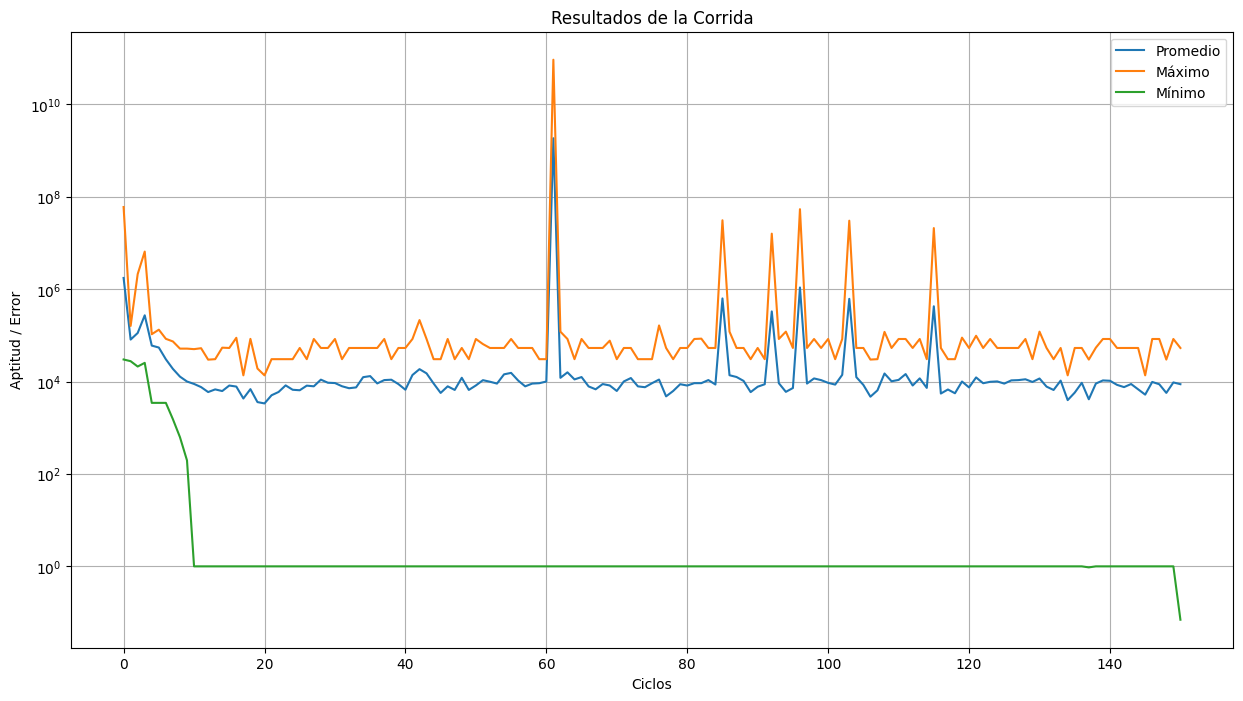

In [13]:
#@title MOSTRAR GRAFICO DE LA CORRIDA

#@title MOSTRAR GRÁFICO DE LA CORRIDA
plt.figure(figsize=(15,8))
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMaxAptitud)
plt.plot(ciclosMinAptitud)
plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud / Error')
plt.legend(['Promedio', 'Máximo', 'Mínimo'], loc='upper right')
plt.grid(True)
USAR_ESCALA_LOG = True #@param {type:"boolean"}
if USAR_ESCALA_LOG:
  plt.yscale('log')
plt.show()



> Mejor Individuo de la Corrida:


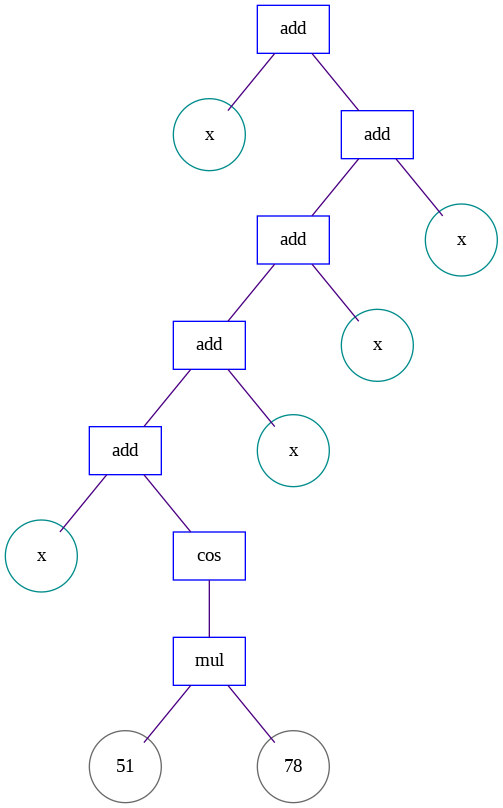



add(x, add(add(add(add(x, cos(mul(51, 78))), x), x), x))


  x 		 yREAL 		 yCALC 		 ERROR
--------------------------------------------------------
   0 		 1 		 0.736 		 0.264
   1 		 6 		 5.736 		 0.264
   2 		 11 		 10.736 		 0.264
   3 		 16 		 15.736 		 0.264
   4 		 21 		 20.736 		 0.264
   5 		 26 		 25.736 		 0.264
   6 		 31 		 30.736 		 0.264
   7 		 36 		 35.736 		 0.264
   8 		 41 		 40.736 		 0.264
   9 		 46 		 45.736 		 0.264
   10 		 51 		 50.736 		 0.264
   11 		 56 		 55.736 		 0.264
   12 		 61 		 60.736 		 0.264
   13 		 66 		 65.736 		 0.264
   14 		 71 		 70.736 		 0.264
   15 		 76 		 75.736 		 0.264
   16 		 81 		 80.736 		 0.264
   17 		 86 		 85.736 		 0.264
   18 		 91 		 90.736 		 0.264
   19 		 96 		 95.736 		 0.264
   20 		 101 		 100.736 		 0.264
   21 		 106 		 105.736 		 0.264
   22 		 111 		 110.736 		 0.264
   23 		 116 		 115.736 		 0.264
   24 		 121 		 120.736 		 0.264
   25 		 126 		 125.736 		 0.264
   26 		 131 		 130.736 		 0.264
   27 		 136 	

In [14]:
#@title MOSTRAR GRAFICO DE LA EXPRESIÓN
## CORRESPONDIENTE AL MEJOR INDIVIDUO
print("\n> Mejor Individuo de la Corrida:")
nodes, edges, labels = gp.graph( mejorIndCorrida )

g = pgv.AGraph(overlap=False, splines='polyline') # indica tipo de uniones
g.graph_attr['label']='' # título
g.graph_attr['ranksep']='0.6' # separación entre niveles
g.graph_attr['nodesep']='1' # separación en el mismo nivel

g.graph_attr['label']=''
g.node_attr['shape']='box'
g.node_attr['color']='blue'
g.edge_attr['color']='indigo'
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]
    if labels[i]=='x':
      n.attr['shape']='circle'
      n.attr['color']='cyan4'
    elif str(labels[i]).isnumeric():
      n.attr['shape']='circle'
      n.attr['color']='dimgray'


# genera una imagen temporal con el árbol y la muestra
auxFile = tempfile.NamedTemporaryFile(suffix=".png")
g.draw(auxFile.name,format="png")
display(Image.open(auxFile.name))

# Aplica y muesta el resultado
print("\n")
print( mejorIndCorrida )
func = toolbox.compile(expr=mejorIndCorrida)
print("\n")
print("  x \t\t yREAL \t\t yCALC \t\t ERROR")
print("--------------------------------------------------------")
error = 0.0
for x, y in zip(ENTRADA, SALIDA):
  calc = func(x)
  error = error + abs(y-calc)
  print("  ", x, "\t\t", round(y, 3), "\t\t", round(calc, 3), "\t\t", round((y-calc), 3) )

print("\n== Error absoluto total: ", round(error,3))
